In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import warnings

sns.set(style="whitegrid")



In [2]:
from pathlib import Path

# Define path to the dataset
csv_path = Path("../data/raw/complaints.csv/complaints.csv")

# Check if file exists
if not csv_path.exists():
    raise FileNotFoundError(f"File not found: {csv_path.resolve()}")

# Load the CSV
df = pd.read_csv(csv_path, low_memory=False)

print("Dataset loaded successfully.")
print("Shape:", df.shape)
df.head()


Dataset loaded successfully.
Shape: (9609797, 18)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687
1,2025-06-20,Debt collection,Telecommunications debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in t...,"Eastern Account Systems of Connecticut, Inc.",FL,342XX,NaN,NaN,Web,2025-06-20,Closed with explanation,Yes,NaN,14195688
2,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195689
3,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195690
4,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,Experian Information Solutions Inc.,IL,60628,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195692


In [3]:
df.head()
df.shape
df.columns


Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9609797 entries, 0 to 9609796
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 1.3+

In [5]:
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    "Missing Count": missing_values,
    "Missing %": missing_percentage
})

missing_df


,Missing Count,Missing %
Company,0,0.000000
Company public response,4770207,49.638999
Company response to consumer,20,0.000208
Complaint ID,0,0.000000
Consumer complaint narrative,6629041,68.982113
Consumer consent provided?,1649561,17.165409
Consumer disputed?,8841498,92.005044
Date received,0,0.000000
Date sent to company,0,0.000000
Issue,6,0.000062


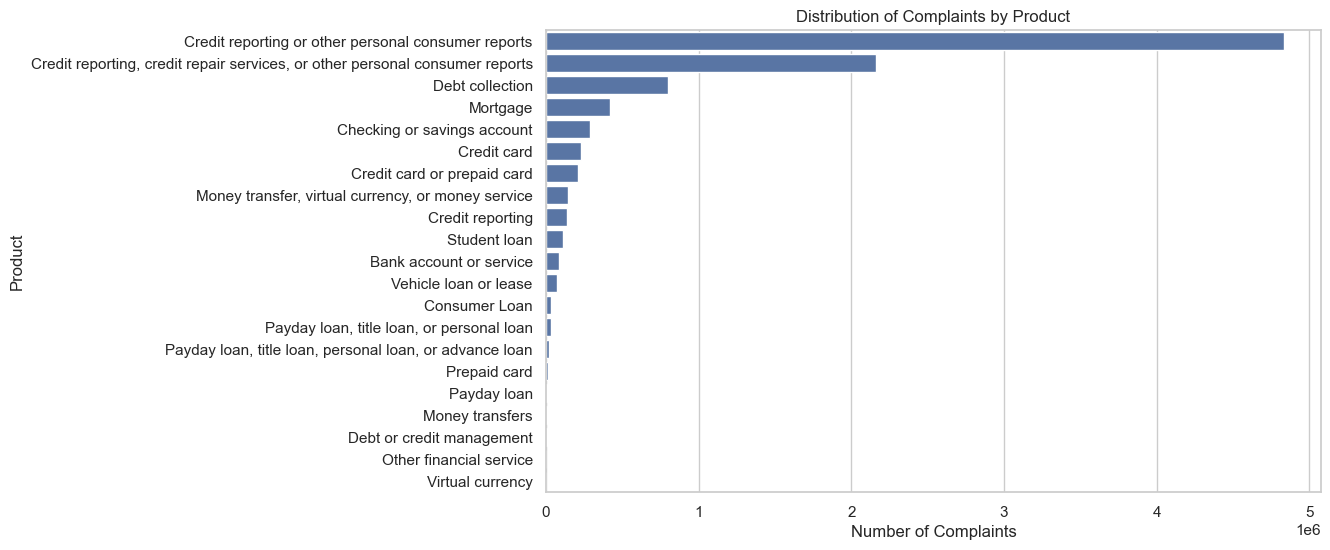

In [6]:
product_counts = df["Product"].value_counts()

plt.figure(figsize=(10,6))
sns.barplot(x=product_counts.values, y=product_counts.index)
plt.title("Distribution of Complaints by Product")
plt.xlabel("Number of Complaints")
plt.ylabel("Product")
plt.show()


In [7]:
df = df[df["Consumer complaint narrative"].notnull()]



In [8]:
df["word_count"] = df["Consumer complaint narrative"].apply(
    lambda x: len(str(x).split())
)



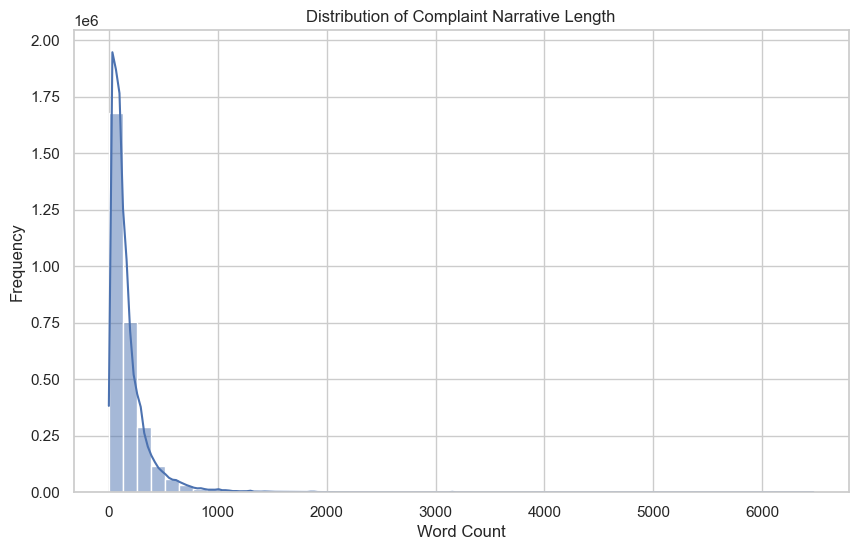

In [9]:
plt.figure(figsize=(10,6))
sns.histplot(df["word_count"], bins=50, kde=True)
plt.title("Distribution of Complaint Narrative Length")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()


In [10]:
short_complaints = df[df["word_count"] < 10]
long_complaints = df[df["word_count"] > 1000]

print("Very Short Complaints:", len(short_complaints))
print("Very Long Complaints:", len(long_complaints))


Very Short Complaints: 21938
Very Long Complaints: 32428


In [13]:
total_complaints = len(df)
with_narrative = df["Consumer complaint narrative"].notnull().sum()
without_narrative = df["Consumer complaint narrative"].isnull().sum()

print("Total complaints:", total_complaints)
print("With narrative:", with_narrative)
print("Without narrative:", without_narrative)


Total complaints: 2118994
With narrative: 2118994
Without narrative: 0


In [11]:
print("Before dedup:", df.shape)

df = df.drop_duplicates(subset=[
    "Consumer complaint narrative",
    "Product",
    "Issue"
])

print("After dedup:", df.shape)


Before dedup: (2980756, 19)
After dedup: (2118994, 19)


In [14]:
import re

def clean_text(text):
    text = str(text)
    
    
    text = text.lower()
    
    
    text = re.sub(r"i am writing to file a complaint.*?\.", "", text)
    text = re.sub(r"this complaint is about.*?\.", "", text)
    
   
    text = re.sub(r'x{2,}', '', text)
    

    text = re.sub(r'http\S+|www\S+', '', text)
    

    text = re.sub(r'\S+@\S+', '', text)
    
   
    text = re.sub(r'[^a-z0-9.,!?\'\s]', ' ', text)
    
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()


In [15]:
df["cleaned_narrative"] = df["Consumer complaint narrative"].apply(clean_text)


In [18]:
from pathlib import Path

final_df = df[[
    "Product",
    "Issue",
    "Company",
    "State",
    "cleaned_narrative",
    "word_count",
]]

# Ensure output directory exists, regardless of notebook cwd
project_root = Path.cwd().resolve()
if project_root.name.lower() == "notebooks":
    project_root = project_root.parent

out_path = project_root / "data" / "processed" / "filtered_complaints.csv"
out_path.parent.mkdir(parents=True, exist_ok=True)
final_df.to_csv(out_path, index=False)
print(f"Saved: {out_path}")

Saved: C:\Users\weldi\Desktop\Complaint_analyisis\rag-complaint-chatbot\data\processed\filtered_complaints.csv
